# Grab X Microsoft Data Science Challenge

**DATA SCIENCE**

Challenge: Traffic Management

Done by:
1. Chuan Hao
2. David
3. Sherisse

In [ ]:
!pip install geolib

In [ ]:
!pip install geolib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geolib import geohash

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

In [ ]:
!wget https://msftgrab.z23.web.core.windows.net/traffic/training.csv 

--2020-11-29 07:33:29--  https://msftgrab.z23.web.core.windows.net/traffic/training.csv
Resolving msftgrab.z23.web.core.windows.net (msftgrab.z23.web.core.windows.net)... 52.239.227.1
Connecting to msftgrab.z23.web.core.windows.net (msftgrab.z23.web.core.windows.net)|52.239.227.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147707728 (141M) [application/vnd.ms-excel]
Saving to: ‘training.csv’

training.csv        100%[===================>] 140.86M   917KB/s    in 58s     

2020-11-29 07:34:29 (2.42 MB/s) - ‘training.csv’ saved [147707728/147707728]



In [ ]:
train = pd.read_csv('training.csv', sep = ',')
train

geohash6  day timestamp    demand
0         qp03wc   18      20:0  0.020072
1         qp03pn   10     14:30  0.024721
2         qp09sw    9      6:15  0.102821
3         qp0991   32       5:0  0.088755
4         qp090q   15       4:0  0.074468
...          ...  ...       ...       ...
4206316   qp03y1   39      13:0  0.012731
4206317   qp097e   23     18:45  0.083179
4206318   qp03m6   32     12:15  0.123260
4206319   qp02zv   42      5:15  0.120100
4206320   qp03yv   15       4:0  0.042656

[4206321 rows x 4 columns]

In [ ]:
train.describe()

day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   geohash6   object 
 1   day        int64  
 2   timestamp  object 
 3   demand     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [ ]:
train['geohash6'].unique()

array(['qp03wc', 'qp03pn', 'qp09sw', ..., 'qp03yn', 'qp09v9', 'qp0d45'],
      dtype=object)

Theorectically, there should be 7,782,624 rows of data. ( 1329 unique geohashs * 61 days * 24 hours * 4 ). 

However, there are currently only 4,206,321 rows of data provided in the .csv file, meaning that there are missing rows of data.

As instructed by the teachers-in-charge, we shall treat all the missing rows of data as data whereby the demand at that point in time is 0. Thus, as there is a difference between having no rows of data and having data whereby the demand is 0, we shall move to fill in the missing rows of data.

### Filling in the missing data

In order to fill in the data, we will first create an empty Pandas DataFrame with the appropriate formatting and columns before slotting in the data from the training.csv file into the empty DataFrame.

In [ ]:
uniqueTimestamps = train['timestamp'].unique()
allDays = [i for i in range(1, 62)]

In [ ]:
new = train.copy()
days = []
tss = []
hss = []
for hash in new['geohash6'].unique():
  for day in allDays:
    for time in uniqueTimestamps:
      days += [day]
      tss += [time]
      hss += [hash]

print(len(days))
print(len(tss))

7782624
7782624


In [ ]:
df = [hss, days, tss]
df = np.array(df)
df = df.T
df = pd.DataFrame(df, columns=['geohash6', 'day', 'timestamp'])
df = df.astype({'day': int})
df['demand'] = 0

In [ ]:
new = df.copy()
new = new.set_index(['geohash6', 'day', 'timestamp'])
new_1 = train.set_index(['geohash6', 'day', 'timestamp'])
new.loc[new_1.index] = new_1

In [ ]:
new = new.reset_index()

In [ ]:
a = new[new['geohash6'] == 'qp09v9']
a[a['demand'] > 0]

geohash6  day timestamp   demand
7775165   qp09v9   45     14:15  0.00222

In [ ]:
len(new['geohash6'].unique()) * 61 * 4 * 24

7782624

In [ ]:
train_df = new
train_df

geohash6  day timestamp    demand
0         qp03wc    1      20:0  0.004959
1         qp03wc    1     14:30  0.272885
2         qp03wc    1      6:15  0.308053
3         qp03wc    1       5:0  0.253679
4         qp03wc    1       4:0  0.267803
...          ...  ...       ...       ...
7782619   qp0d45   61     19:45  0.000000
7782620   qp0d45   61      19:0  0.000000
7782621   qp0d45   61       0:0  0.000000
7782622   qp0d45   61     17:30  0.000000
7782623   qp0d45   61     20:15  0.000000

[7782624 rows x 4 columns]

### EDA / Feature Engineering

#### Adding a Lat and Long Column based on the geohash6 value

* Lat == North-South Coordinate Position
* Lon == East-West Coordinate Position

In [ ]:
uniqueGeohash = train.geohash6.unique()

In [ ]:
# Creating two empty columns that will
# hold the value of the lat and long coordinates
train_df['lon'] = ''
train_df['lat'] = ''

In [ ]:
for geohash6 in uniqueGeohash:
  train_df['lat'] = np.where((train_df.geohash6 == geohash6), geohash.decode(geohash6)[0], train_df.lat)
  train_df['lon'] = np.where((train_df.geohash6 == geohash6), geohash.decode(geohash6)[1], train_df.lon)

In [ ]:
train_df

geohash6  day timestamp    demand               lon                lat
0         qp03wc    1      20:0  0.004959  90.6536865234375  -5.35308837890625
1         qp03wc    1     14:30  0.272885  90.6536865234375  -5.35308837890625
2         qp03wc    1      6:15  0.308053  90.6536865234375  -5.35308837890625
3         qp03wc    1       5:0  0.253679  90.6536865234375  -5.35308837890625
4         qp03wc    1       4:0  0.267803  90.6536865234375  -5.35308837890625
...          ...  ...       ...       ...               ...                ...
7782619   qp0d45   61     19:45  0.000000  90.7965087890625  -5.25421142578125
7782620   qp0d45   61      19:0  0.000000  90.7965087890625  -5.25421142578125
7782621   qp0d45   61       0:0  0.000000  90.7965087890625  -5.25421142578125
7782622   qp0d45   61     17:30  0.000000  90.7965087890625  -5.25421142578125
7782623   qp0d45   61     20:15  0.000000  90.7965087890625  -5.25421142578125

[7782624 rows x 6 columns]

#### General Traffic demand by Region ( Lat and Lon )

*Aggregated by mean

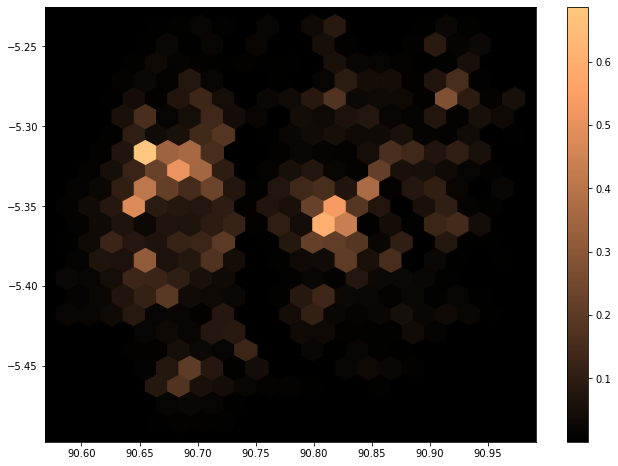

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))

hexPlot = plt.hexbin(x = train_df['lon'], y = train_df['lat'], C = train_df['demand'],
                     gridsize = 20, cmap = 'copper')

fig.colorbar(hexPlot, ax=ax)
ax.set_facecolor('black') # Fill the grids where there isnt any data with a set color

From this HexPlot, we can immediately find the regions with relatively larger traffic demand over the course of all 61 days as well as those with relatively lower traffic demand.

For the purposes of better analysis, we shall only look at areas where there are traffic demand in order to determine these regions. As such, we will not focus on areas where, according to the HexPlot, it seems as if there is almost no traffic demand such as the large black area at the bottom left of the plot.

Regions with obviously larger demand ( Estimated lat and lon range ):

    * Region1 -> ( -5.30 to -5.40 ), ( 90.60 to 90.75 )
    * Region2 -> ( -5.33 to -5.40 ), ( 90.75 to 90.85 )


Region of relatively lower demand ( Estimated lat and lon range ):

    * Small region below region 1 -> ( -5.40 to -5.50 ), ( 90.65 to 90.75 )
    * Region to the right of region 2 -> ( -5.30 to -5.40 ), ( 90.87 to 90.95 )

#### Preparing the time-related data

In order to make a better analysis, we will assume that each of the days in the dataset are consecutive to each other and that day 1 is also the start of the week ( i.e. is a Monday )

This will thus allow us to make a better analysis of the changes in the traffic demand over the course of the 61 days by allowing us to separate the data into different weeks and days.

In [ ]:
splitTime = train_df.timestamp.str.split(':', expand = True)

In [ ]:
timeDf = train_df
timeDf['hour'] = splitTime[0].astype(int)
timeDf['minute'] = splitTime[1].astype(int)
timeDf

geohash6  day timestamp  ...                lat hour minute
0         qp03wc    1      20:0  ...  -5.35308837890625   20      0
1         qp03wc    1     14:30  ...  -5.35308837890625   14     30
2         qp03wc    1      6:15  ...  -5.35308837890625    6     15
3         qp03wc    1       5:0  ...  -5.35308837890625    5      0
4         qp03wc    1       4:0  ...  -5.35308837890625    4      0
...          ...  ...       ...  ...                ...  ...    ...
7782619   qp0d45   61     19:45  ...  -5.25421142578125   19     45
7782620   qp0d45   61      19:0  ...  -5.25421142578125   19      0
7782621   qp0d45   61       0:0  ...  -5.25421142578125    0      0
7782622   qp0d45   61     17:30  ...  -5.25421142578125   17     30
7782623   qp0d45   61     20:15  ...  -5.25421142578125   20     15

[7782624 rows x 8 columns]

In [ ]:
#* A function to separate the data by their weeks
def seperateWeeks(x):
    weekVal = int(x / 7)
    if x % 7 != 0:
        weekVal += 1

    return weekVal

In [ ]:
weekDay = []
weekEnd = []
allDays = [i for i in range(train_df['day'].min(), train_df['day'].max() + 1)] 

for i in range(len(allDays)):
    currentDay = allDays[i]
    if currentDay % 7 == 0:
        weekEnd.append(allDays[i - 1])
        weekDay.remove(allDays[i - 1])

        weekEnd.append(currentDay)

    else:
        weekDay.append(currentDay)

print("weekDay: {}".format(weekDay))
print("weekEnd: {}".format(weekEnd))

weekDay: [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61]
weekEnd: [6, 7, 13, 14, 20, 21, 27, 28, 34, 35, 41, 42, 48, 49, 55, 56]


In [ ]:
#* A function to determine if the data is a weekday or a weekend
def seperateDays(x, weekDay, weekEnd):
    if x in weekDay:
        return "WeekDay"

    elif x in weekEnd:
        return "WeekEnd"

#### Regions with High Demand

##### First Region, cluster of areas with relatively high demand to the left of the general HexPlot

In [ ]:
region1 = timeDf[timeDf['lat'] >= -5.40]
region1 = region1[region1['lat'] <= -5.30]
region1 = region1[region1['lon'] >= 90.60]
region1 = region1[region1['lon'] <= 90.75]
region1

geohash6  day timestamp  ...                lat hour minute
0         qp03wc    1      20:0  ...  -5.35308837890625   20      0
1         qp03wc    1     14:30  ...  -5.35308837890625   14     30
2         qp03wc    1      6:15  ...  -5.35308837890625    6     15
3         qp03wc    1       5:0  ...  -5.35308837890625    5      0
4         qp03wc    1       4:0  ...  -5.35308837890625    4      0
...          ...  ...       ...  ...                ...  ...    ...
7319995   qp098v   61     19:45  ...  -5.33111572265625   19     45
7319996   qp098v   61      19:0  ...  -5.33111572265625   19      0
7319997   qp098v   61       0:0  ...  -5.33111572265625    0      0
7319998   qp098v   61     17:30  ...  -5.33111572265625   17     30
7319999   qp098v   61     20:15  ...  -5.33111572265625   20     15

[1270752 rows x 8 columns]

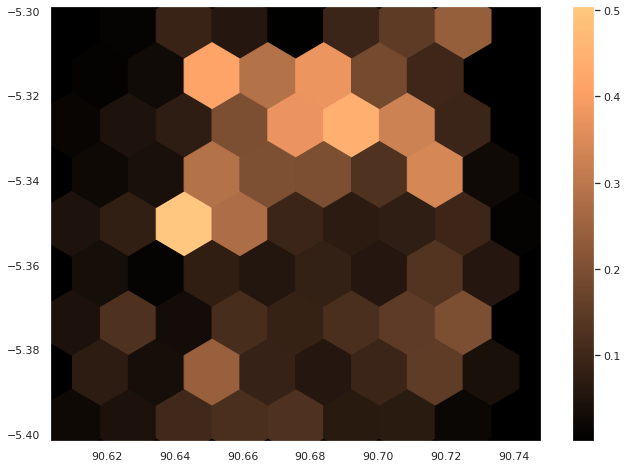

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

hexPlot = plt.hexbin(x = region1['lon'], y = region1['lat'], C = region1['demand'],
                     gridsize = 8, cmap = 'copper')

fig.colorbar(hexPlot, ax=ax)
ax.set_facecolor('black') # Fill the grids where there isnt any data with a set color, 'black'

As expected, this region has relatively high demand over the course of all 61 days. 

There is a large cluster around the middle which has the highest traffic demand of close to 0.5 while the grids leading up to it has a relatively smaller traffic demand of around 0.2 to 0.4. 

There could be multiple reasons for this, such as the large cluster itself being the Central Business District (CBD) of a country, or maybe even a small city or town in itself.

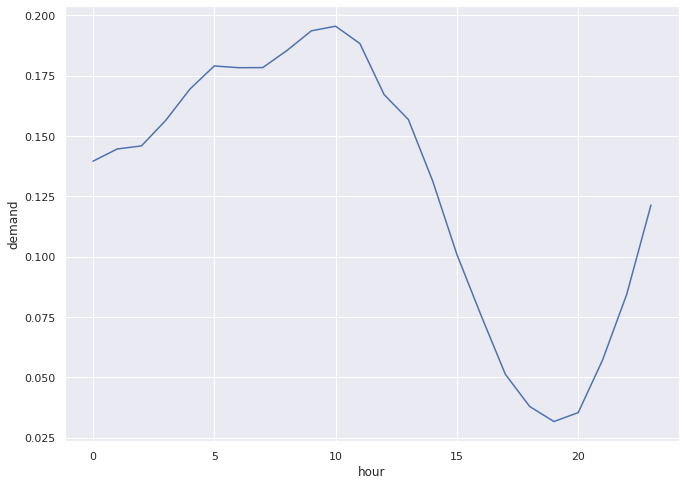

In [ ]:
sns.set(rc = {
    'figure.figsize': (11, 8)
})

sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = region1)

In [ ]:
region1['weekNum'] = region1.day.apply(lambda x: seperateWeeks(x))
region1['weekNum'] = region1['weekNum'].astype('string')
region1

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
0         qp03wc    1      20:0  0.004959  ...   20      0        1  WeekDay
1         qp03wc    1     14:30  0.272885  ...   14     30        1  WeekDay
2         qp03wc    1      6:15  0.308053  ...    6     15        1  WeekDay
3         qp03wc    1       5:0  0.253679  ...    5      0        1  WeekDay
4         qp03wc    1       4:0  0.267803  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7319995   qp098v   61     19:45  0.000000  ...   19     45        9  WeekDay
7319996   qp098v   61      19:0  0.000000  ...   19      0        9  WeekDay
7319997   qp098v   61       0:0  0.000000  ...    0      0        9  WeekDay
7319998   qp098v   61     17:30  0.000000  ...   17     30        9  WeekDay
7319999   qp098v   61     20:15  0.000000  ...   20     15        9  WeekDay

[1270752 rows x 10 columns]

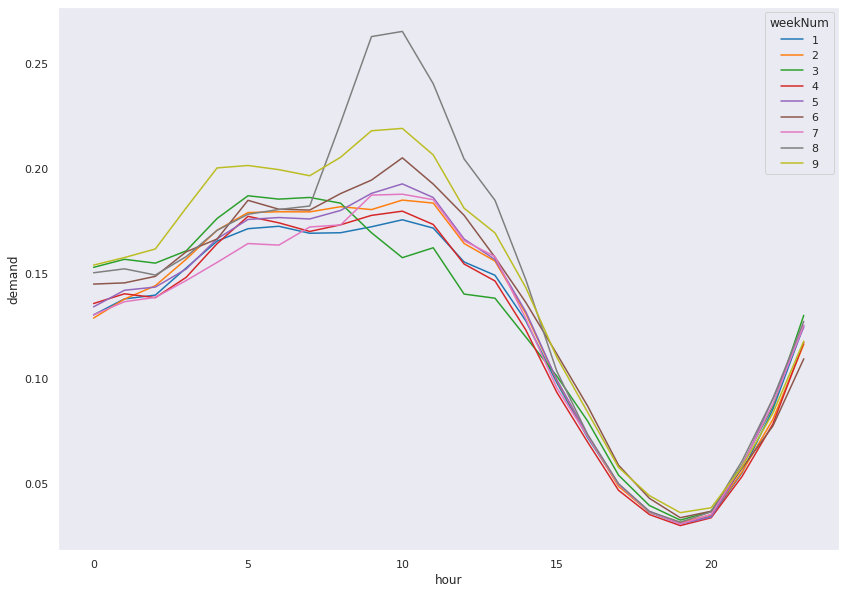

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = region1,
             ci = None, palette = "tab10")

There is a general pattern to the changes in traffic demand over the course of a single day for all 9 weeks. 

The traffic demand starts rising slowly at the start of each day before reaching its peak somewhere around 0900 to 1000 hours, which is as expected as this coincides with the morning peak hour period whereby people would be rushing to work, heading to school and/or sending their children to school

Afterwhich, the traffic demand steadily decreases until around 1900 hours whereby the traffic demand starts to steadily increase again without stopping and into the next day. 

This, on the other hand, is outside our expectations. We expected the traffic demand to start increasing around 1800 hours, which is roughly close to what can be seen from the plot, but also that it would decrease somewhere around 2200 hours, after the evening peak hour. However, the traffic demand actually continued increasing, indicating that the traffic demand at midnight is actually larger than during the evening peak hour period when most would be heading home.

Additionally, there is also a very large spike in the traffic demand in week 8, days 50 to 56. Week 9 also has a relatively smaller spike but week 7 seems to have a roughly average traffic demand.

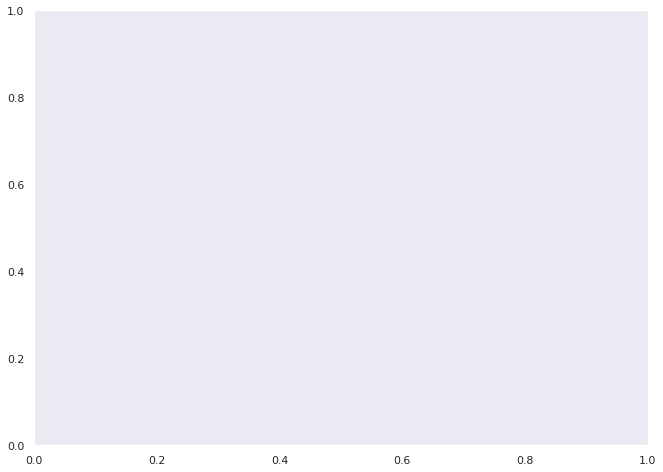

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

def update(i):
    currentDate = allDays[i]

    data = region1[region1['day'] == currentDate]
    hexPlot = ax.hexbin(x = data['lon'], y = data['lat'], C = data['demand'], 
                        gridsize = 8, cmap = 'copper')

    currentWeek = int(i / 7) + 1
    dayOfWeek = int(i % 7) + 1

    ax.set_title("Region 1: Week {}, Day {}".format(currentWeek, dayOfWeek))
    ax.set_facecolor('black')

    return hexPlot

In [ ]:
animate = FuncAnimation(fig, update, repeat = True, 
                        interval = 600, frames = len(allDays))

HTML(animate.to_html5_video())

From the animation, it seems as if the traffic demand stays within the same region and does not move to a seperate area on different days.

Interestingly, there seems to be a trend whereby the traffic demand spreads to a slightly larger area on days 6 and 7, which may be due to the fact that these days are the Weekends which means that more people are moving around and not staying in school, at their offices or at home.

But, does this mean that the traffic demand is larger on weekends as compared to weekdays?

In [ ]:
region1['dayType'] = region1.day.apply(lambda x: seperateDays(x, weekDay, weekEnd))
region1['dayType'].astype("string")
region1

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
0         qp03wc    1      20:0  0.004959  ...   20      0        1  WeekDay
1         qp03wc    1     14:30  0.272885  ...   14     30        1  WeekDay
2         qp03wc    1      6:15  0.308053  ...    6     15        1  WeekDay
3         qp03wc    1       5:0  0.253679  ...    5      0        1  WeekDay
4         qp03wc    1       4:0  0.267803  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7319995   qp098v   61     19:45  0.000000  ...   19     45        9  WeekDay
7319996   qp098v   61      19:0  0.000000  ...   19      0        9  WeekDay
7319997   qp098v   61       0:0  0.000000  ...    0      0        9  WeekDay
7319998   qp098v   61     17:30  0.000000  ...   17     30        9  WeekDay
7319999   qp098v   61     20:15  0.000000  ...   20     15        9  WeekDay

[1270752 rows x 10 columns]

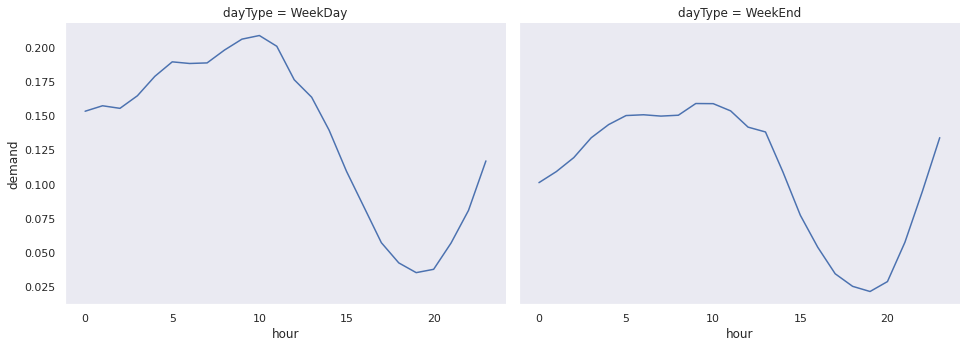

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(region1, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

Contrary to expectations, the traffic demand does not seem to be larger on weekends as compared to weekdays. 

In fact, the traffic demand on weekdays are actually significantly larger than that on weekends, especially during the morning peak hour. Additionally, the traffic demand on weekends actually have a lower minimum demand than that of weekdays.

This could indicate that this region is not one with a large amount of entertainment facilities or shops as the traffic demand in the region is smaller during weekends but the spread of traffic demand is actually larger which may be due to the fact that people are moving out of the region to relax during the weekends and travel within the region during the weekdays for work or school.

##### Second region, cluster of areas with relatively high demand to the right on the general HexPlot

Now, let us cross check our findings in the first region with that of another region with similarly high demand to determine if there are any common similarites between them.

In [ ]:
region2 = timeDf[timeDf['lat'] >= -5.40]
region2 = region2[region2['lat'] <= -5.33]
region2 = region2[region2['lon'] >= 90.75]
region2 = region2[region2['lon'] <= 90.85]
region2

geohash6  day timestamp  ...                lat hour minute
17568     qp0991    1      20:0  ...  -5.35308837890625   20      0
17569     qp0991    1     14:30  ...  -5.35308837890625   14     30
17570     qp0991    1      6:15  ...  -5.35308837890625    6     15
17571     qp0991    1       5:0  ...  -5.35308837890625    5      0
17572     qp0991    1       4:0  ...  -5.35308837890625    4      0
...          ...  ...       ...  ...                ...  ...    ...
7729915   qp093h   61     19:45  ...  -5.38055419921875   19     45
7729916   qp093h   61      19:0  ...  -5.38055419921875   19      0
7729917   qp093h   61       0:0  ...  -5.38055419921875    0      0
7729918   qp093h   61     17:30  ...  -5.38055419921875   17     30
7729919   qp093h   61     20:15  ...  -5.38055419921875   20     15

[685152 rows x 8 columns]

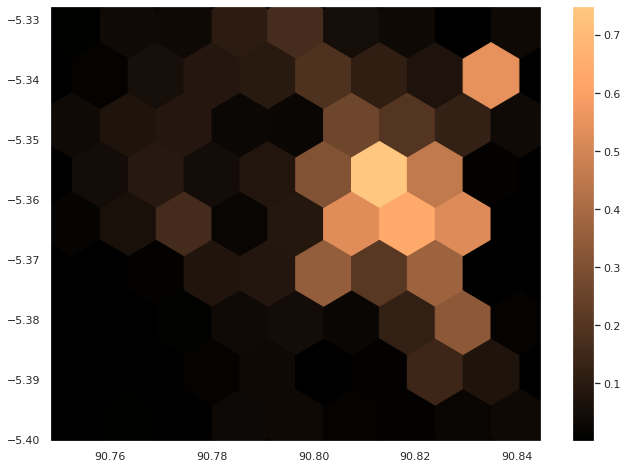

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

hexPlot = plt.hexbin(x = region2['lon'], y = region2['lat'], C = region2['demand'],
                     gridsize = 8, cmap = 'copper')

fig.colorbar(hexPlot, ax=ax)
ax.set_facecolor('black') # Fill the grids where there isnt any data with a set color, 'black'

Similar to the first region, there is a large cluster near the middle with a number of grids leading up to it with higher and higher traffic demand as it gets closer to the cluster of high demand areas.

So far, this seems to support our theory that regions with relatively high demand could be CBD areas or cities.

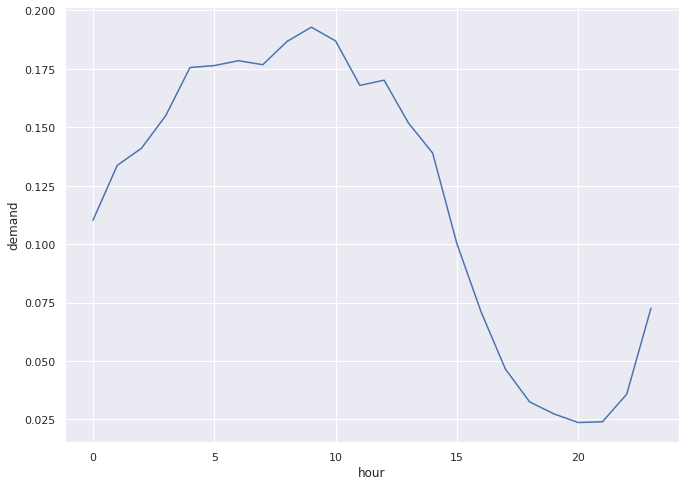

In [ ]:
sns.set(rc = {
    'figure.figsize': (11, 8)
})

sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = region2)

In [ ]:
region2['weekNum'] = region2.day.apply(lambda x: seperateWeeks(x))
region2['weekNum'] = region2['weekNum'].astype('string')
region2

geohash6  day timestamp  ...  hour minute weekNum
17568     qp0991    1      20:0  ...    20      0       1
17569     qp0991    1     14:30  ...    14     30       1
17570     qp0991    1      6:15  ...     6     15       1
17571     qp0991    1       5:0  ...     5      0       1
17572     qp0991    1       4:0  ...     4      0       1
...          ...  ...       ...  ...   ...    ...     ...
7729915   qp093h   61     19:45  ...    19     45       9
7729916   qp093h   61      19:0  ...    19      0       9
7729917   qp093h   61       0:0  ...     0      0       9
7729918   qp093h   61     17:30  ...    17     30       9
7729919   qp093h   61     20:15  ...    20     15       9

[685152 rows x 9 columns]

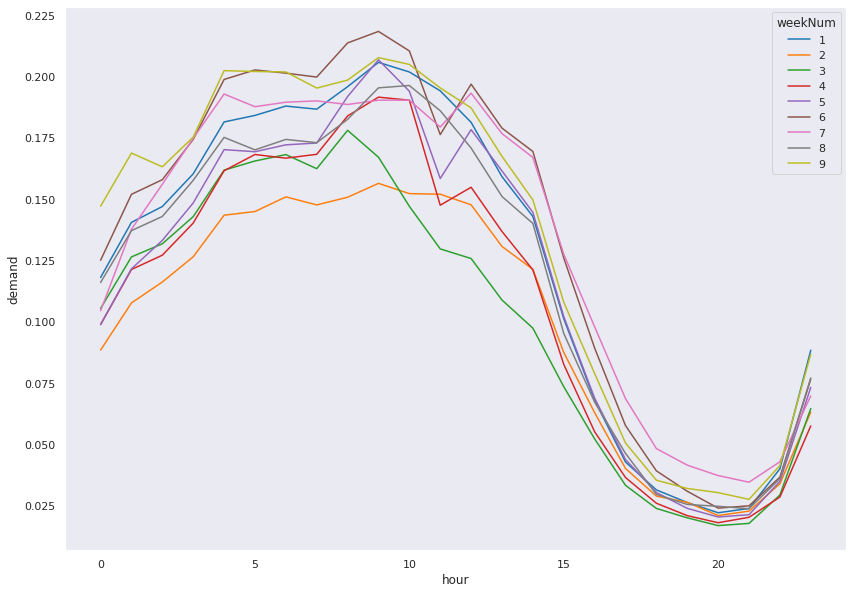

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = region2,
             ci = None, palette = "tab10")

However, the traffic demand seems to very drastically between each week for this second region as compared to region 1 where the traffic demand seems to remain relatively similar aside from week 8.

Additionally, it seems that for this region, week 8 is not the outlier with the highest traffic demand but is instead one of the weeks with an average traffic demand.

For this region, it seems as though week 6 has the highest traffic demand. In fact, it seems as if the traffic demand starts to rise from week 2 onwards and maintains this constant increase in traffic demand until week 6 whereby it starts to decrease.

Regardless, the general pattern of traffic demand over the course of a single day seems to be similar for both regions 1 and 2.

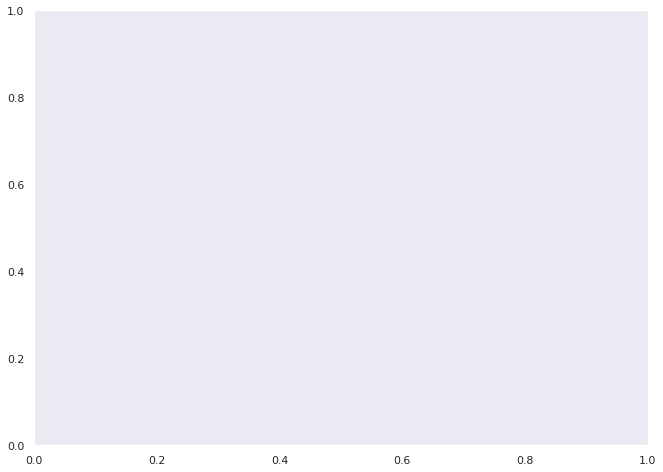

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

def update(i):
    currentDate = allDays[i]

    data = region2[region2['day'] == currentDate]
    hexPlot = ax.hexbin(x = data['lon'], y = data['lat'], C = data['demand'], 
                        gridsize = 8, cmap = 'copper')

    currentWeek = int(i / 7) + 1
    dayOfWeek = int(i % 7) + 1

    ax.set_title("Region 2: Week {}, Day {}".format(currentWeek, dayOfWeek))
    ax.set_facecolor('black')

    return hexPlot

In [ ]:
animate = FuncAnimation(fig, update, repeat = True, 
                        interval = 600, frames = len(allDays))

HTML(animate.to_html5_video())

Interestingly, this is another pattern whereby the 2 regions are similar.

The traffic demand is more concentrated in the large cluster during the weekdays but tends to spread out more over the weekends. However, this pattern only starts to occur after the first day of the week. 

On day 1 of most, if not all, weeks, the spread of traffic demand is similar to that of the spread on day 7. However, the traffic demand then becomes concentrated in a small cluster starting from day 2.

In [ ]:
region2['dayType'] = region2.day.apply(lambda x: seperateDays(x, weekDay, weekEnd))
region2['dayType'].astype("string")
region2

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
17568     qp0991    1      20:0  0.000000  ...   20      0        1  WeekDay
17569     qp0991    1     14:30  0.109102  ...   14     30        1  WeekDay
17570     qp0991    1      6:15  0.084803  ...    6     15        1  WeekDay
17571     qp0991    1       5:0  0.110125  ...    5      0        1  WeekDay
17572     qp0991    1       4:0  0.113121  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7729915   qp093h   61     19:45  0.000000  ...   19     45        9  WeekDay
7729916   qp093h   61      19:0  0.000000  ...   19      0        9  WeekDay
7729917   qp093h   61       0:0  0.000000  ...    0      0        9  WeekDay
7729918   qp093h   61     17:30  0.000000  ...   17     30        9  WeekDay
7729919   qp093h   61     20:15  0.000000  ...   20     15        9  WeekDay

[685152 rows x 10 columns]

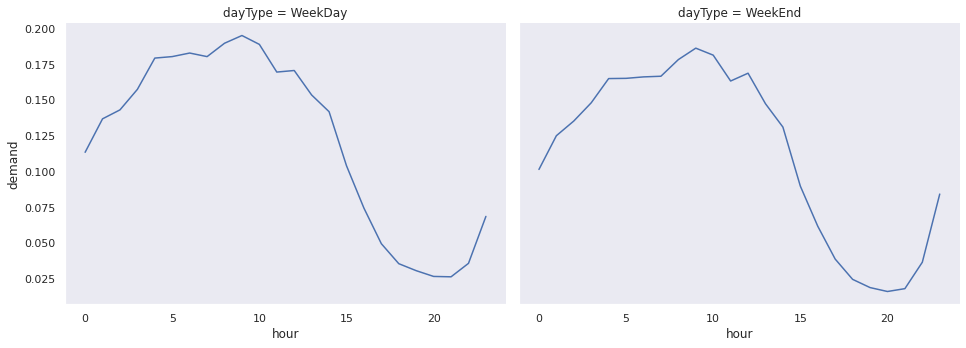

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(region2, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

In contrast to region 1 however, the traffic demand seems to be relatively similar regardless of whether it is currently a weekday or weekend, aside from a small decrease in the traffic demand during the morning peak hour period.

However, the traffic demand during midnight on weekends is actually larger than that of the traffic demand on weekdays. This may actually indicate that this second region is a large entertainment area as the consistent high traffic demand during midnight and the wee hours of the morning, regardless of whether it is a weekday or weekend, are due to people staying out late to relax and enjoy themselves.

##### High Demand Regions in summary 

In [ ]:
highDemandRegions = pd.concat([region1, region2])
highDemandRegions

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
0         qp03wc    1      20:0  0.004959  ...   20      0        1  WeekDay
1         qp03wc    1     14:30  0.272885  ...   14     30        1  WeekDay
2         qp03wc    1      6:15  0.308053  ...    6     15        1  WeekDay
3         qp03wc    1       5:0  0.253679  ...    5      0        1  WeekDay
4         qp03wc    1       4:0  0.267803  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7729915   qp093h   61     19:45  0.000000  ...   19     45        9  WeekDay
7729916   qp093h   61      19:0  0.000000  ...   19      0        9  WeekDay
7729917   qp093h   61       0:0  0.000000  ...    0      0        9  WeekDay
7729918   qp093h   61     17:30  0.000000  ...   17     30        9  WeekDay
7729919   qp093h   61     20:15  0.000000  ...   20     15        9  WeekDay

[1955904 rows x 10 columns]

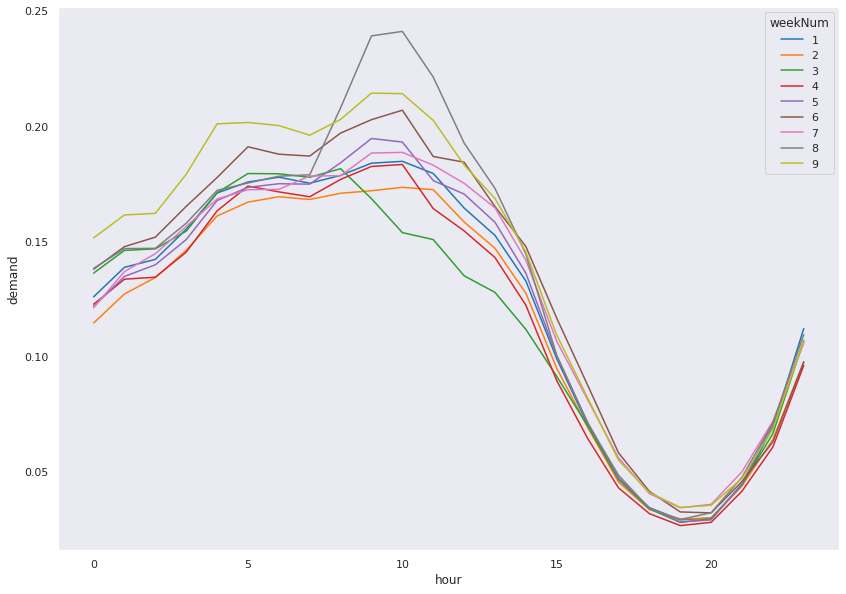

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = highDemandRegions,
             ci = None, palette = "tab10")

From this, it seems as if we can conclude that the traffic demand holds the same pattern over the course a single day regardless of the week.

Additionally, we can see that starting from week 6, and going into week 9, the average traffic demand each week is actually increasing. This may indicate that weeks 6 to 9 are weeks that are during the school holidays period and thus, parents are taking time off to spend with their children which would explain the larger traffic demand.

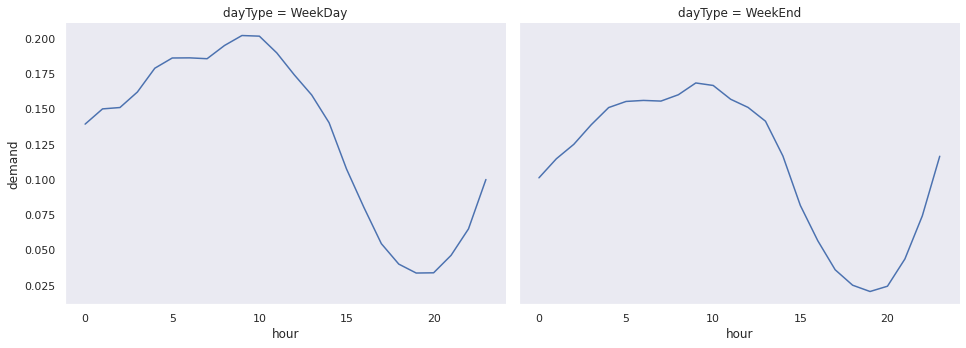

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(highDemandRegions, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

The trend for traffic demand on weekdays versus. weekends are actually similar for all regions with high demand and for the second region, where the traffic demand is relatively similar for the second half of the day and the traffic demand on weekdays are higher than that of the traffic demand on weekends for the first half of the day.

#### Regions with Low Demand

##### First Region with relatively low demand, cluster slightly to the bottom of the first region with relatively high demand ( Will be called region3 for the purposes of this analysis )

In [ ]:
region3 = timeDf[timeDf['lat'] >= -5.50]
region3 = region3[region3['lat'] <= -5.42]
region3 = region3[region3['lon'] >= 90.65]
region3 = region3[region3['lon'] <= 90.75]
region3

geohash6  day timestamp  ...                lat hour minute
486048    qp02zz    1      20:0  ...  -5.45196533203125   20      0
486049    qp02zz    1     14:30  ...  -5.45196533203125   14     30
486050    qp02zz    1      6:15  ...  -5.45196533203125    6     15
486051    qp02zz    1       5:0  ...  -5.45196533203125    5      0
486052    qp02zz    1       4:0  ...  -5.45196533203125    4      0
...          ...  ...       ...  ...                ...  ...    ...
7665499   qp02yu   61     19:45  ...  -5.46844482421875   19     45
7665500   qp02yu   61      19:0  ...  -5.46844482421875   19      0
7665501   qp02yu   61       0:0  ...  -5.46844482421875    0      0
7665502   qp02yu   61     17:30  ...  -5.46844482421875   17     30
7665503   qp02yu   61     20:15  ...  -5.46844482421875   20     15

[562176 rows x 8 columns]

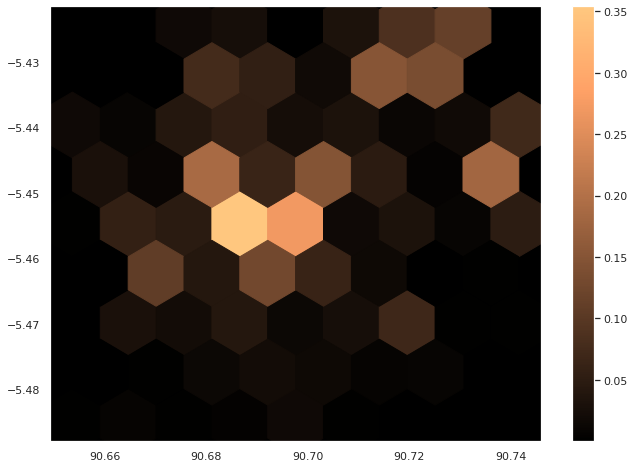

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

hexPlot = plt.hexbin(x = region3['lon'], y = region3['lat'], C = region3['demand'],
                     gridsize = 8, cmap = 'copper')

fig.colorbar(hexPlot, ax=ax)
ax.set_facecolor('black') # Fill the grids where there isnt any data with a set color, 'black'

Now that we are focusing on this region, we can see that there is a small area whereby the traffic demand is actually quite high. Of course, in comparison to the entire region of the dataset, this demand is relatively low at around 0.3 to 0.35.

In [ ]:
sns.set(rc = {
    'figure.figsize': (11, 8)
})

sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = region3)

In [ ]:
region3['weekNum'] = region3.day.apply(lambda x: seperateWeeks(x))
region3['weekNum'] = region3['weekNum'].astype('string')
region3

geohash6  day timestamp  ...  hour minute weekNum
486048    qp02zz    1      20:0  ...    20      0       1
486049    qp02zz    1     14:30  ...    14     30       1
486050    qp02zz    1      6:15  ...     6     15       1
486051    qp02zz    1       5:0  ...     5      0       1
486052    qp02zz    1       4:0  ...     4      0       1
...          ...  ...       ...  ...   ...    ...     ...
7665499   qp02yu   61     19:45  ...    19     45       9
7665500   qp02yu   61      19:0  ...    19      0       9
7665501   qp02yu   61       0:0  ...     0      0       9
7665502   qp02yu   61     17:30  ...    17     30       9
7665503   qp02yu   61     20:15  ...    20     15       9

[562176 rows x 9 columns]

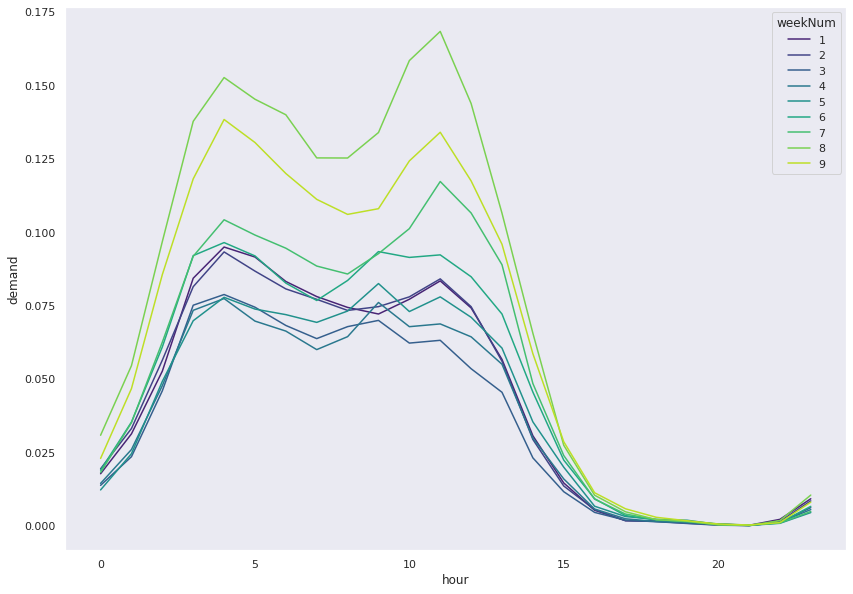

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = region3,
             ci = None, palette = "viridis")

Interestingly, this pattern of demand over the course of a single day is not similar to that of the pattern for regions with high demand.

While the traffic demand does also increase from the start of the day, it actually drops between about 0400 to 0800 which also encompasses the start of the usual morning peak hour period. 

However, the traffic demand does start rising at around 0900 hours until about 1100 hours where the demand start dropping drastically, hitting around 0 demand after 1500 hours.

Of course, this is highly doubtful to be a real projection of the traffic demand over the course of the day. The most likely explanation is that the data for the region after 1500 hours was missing in the original dataset provided and the 0 demand shown is a result of us filling in the missing rows in the dataset.

As such, while we can likely still perform some analysis on this region, it may be better for us to focus on the mornings as well as to not use this region as the general baseline for all regions with low demand.

In fact, this region could very well actually have relatively high demand if the demand during the afternoon, after 1500 hours, follows the same trend as that of the other high demand regions we have seen.

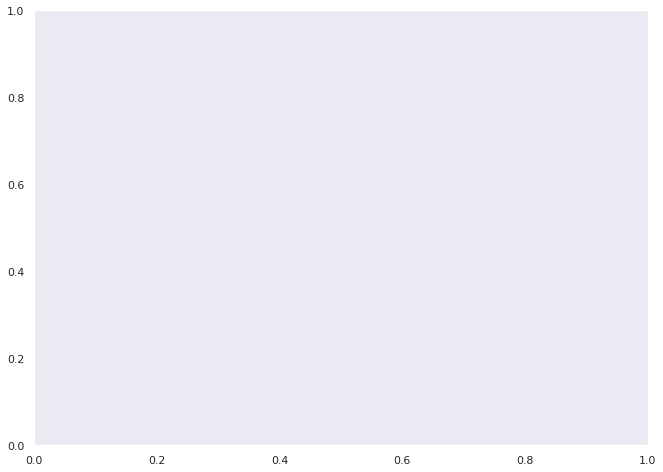

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

def update(i):
    currentDate = allDays[i]

    data = region3[region3['day'] == currentDate]
    hexPlot = ax.hexbin(x = data['lon'], y = data['lat'], C = data['demand'], 
                        gridsize = 8, cmap = 'copper')

    currentWeek = int(i / 7) + 1
    dayOfWeek = int(i % 7) + 1

    ax.set_title("Region 3: Week {}, Day {}".format(currentWeek, dayOfWeek))
    ax.set_facecolor('black')

    return hexPlot

In [ ]:
animate = FuncAnimation(fig, update, repeat = True, 
                        interval = 600, frames = len(allDays))

HTML(animate.to_html5_video())

Interestingly however, the spread of traffic demand does not seem to change much over the course of a week unlike what we have observed previously in regions with relatively high demand. 

Instead, the spread seems relatively constant and the main change over the course of the week seems to only be a relatively larger demand during the weekdays as compared to the weekends.

In [ ]:
region3['dayType'] = region3.day.apply(lambda x: seperateDays(x, weekDay, weekEnd))
region3['dayType'].astype("string")
region3

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
486048    qp02zz    1      20:0  0.000000  ...   20      0        1  WeekDay
486049    qp02zz    1     14:30  0.391962  ...   14     30        1  WeekDay
486050    qp02zz    1      6:15  1.000000  ...    6     15        1  WeekDay
486051    qp02zz    1       5:0  0.871147  ...    5      0        1  WeekDay
486052    qp02zz    1       4:0  0.832315  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7665499   qp02yu   61     19:45  0.000000  ...   19     45        9  WeekDay
7665500   qp02yu   61      19:0  0.000000  ...   19      0        9  WeekDay
7665501   qp02yu   61       0:0  0.000000  ...    0      0        9  WeekDay
7665502   qp02yu   61     17:30  0.000000  ...   17     30        9  WeekDay
7665503   qp02yu   61     20:15  0.000000  ...   20     15        9  WeekDay

[562176 rows x 10 columns]

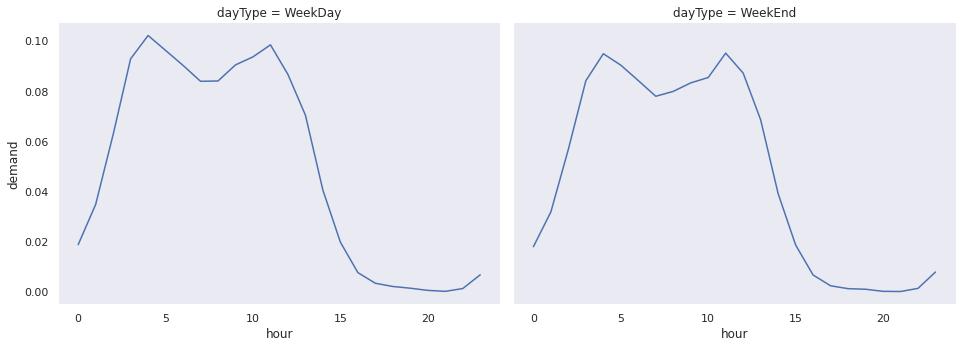

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(region3, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

Similar to regions with high demand, the pattern of traffic demand is similar for both weekdays and weekends. 

In fact, there is almost no difference aside from the slight decrease in the traffic demand in the mornings which was also observed in regions with high demand.

This lends more credence to the theory that this region could in fact be classified as a region of high demand if not for the missing rows of data after 1500 hours which decreased the mean demand for the region enough to make it seems as if it was a region with relatively low demand as compared to the other regions.

##### Second region with relatively low demand, cluster slightly to the right of the second region with relatively high demand. ( Will be called region4 for the purposes of this analysis )

In order to better determine whether the above region, region 3 and the first region with relatively low demand, could actually be a region with relatively high demand, we can look at another region with what seems to be relatively low demand.

This can also help us determine any trends specific to regions with low demand.

In [ ]:
region4 = timeDf[timeDf['lat'] >= -5.40]
region4 = region4[region4['lat'] <= -5.30]
region4 = region4[region4['lon'] >= 90.87]
region4 = region4[region4['lon'] <= 90.95]
region4

geohash6  day timestamp  ...                lat hour minute
11712     qp09sw    1      20:0  ...  -5.32562255859375   20      0
11713     qp09sw    1     14:30  ...  -5.32562255859375   14     30
11714     qp09sw    1      6:15  ...  -5.32562255859375    6     15
11715     qp09sw    1       5:0  ...  -5.32562255859375    5      0
11716     qp09sw    1       4:0  ...  -5.32562255859375    4      0
...          ...  ...       ...  ...                ...  ...    ...
7753339   qp09s5   61     19:45  ...  -5.34210205078125   19     45
7753340   qp09s5   61      19:0  ...  -5.34210205078125   19      0
7753341   qp09s5   61       0:0  ...  -5.34210205078125    0      0
7753342   qp09s5   61     17:30  ...  -5.34210205078125   17     30
7753343   qp09s5   61     20:15  ...  -5.34210205078125   20     15

[691008 rows x 8 columns]

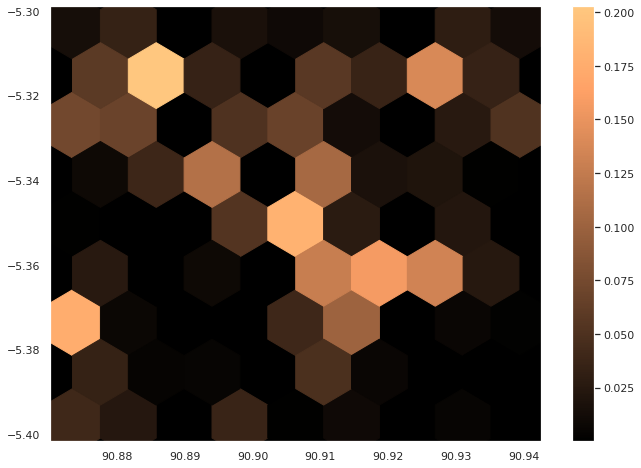

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

hexPlot = plt.hexbin(x = region4['lon'], y = region4['lat'], C = region4['demand'],
                     gridsize = 8, cmap = 'copper')

fig.colorbar(hexPlot, ax=ax)
ax.set_facecolor('black') # Fill the grids where there isnt any data with a set color, 'black'

Similar to region 3, when looked at more closely, this region seems to have quite a large demand. 

However, if we relate the plot back to the color bar legend by the side, we can see that the areas showing a relatively high demand actually have quite low demands of around 0.15 to 0.2, which is even lower than that of what seems to be the highest demand in region 3, 0.3 to 0.35.

In [ ]:
sns.set(rc = {
    'figure.figsize': (11, 8)
})

sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = region4)

In [ ]:
region4['weekNum'] = region4.day.apply(lambda x: seperateWeeks(x))
region4['weekNum'] = region4['weekNum'].astype('string')
region4

geohash6  day timestamp  ...  hour minute weekNum
11712     qp09sw    1      20:0  ...    20      0       1
11713     qp09sw    1     14:30  ...    14     30       1
11714     qp09sw    1      6:15  ...     6     15       1
11715     qp09sw    1       5:0  ...     5      0       1
11716     qp09sw    1       4:0  ...     4      0       1
...          ...  ...       ...  ...   ...    ...     ...
7753339   qp09s5   61     19:45  ...    19     45       9
7753340   qp09s5   61      19:0  ...    19      0       9
7753341   qp09s5   61       0:0  ...     0      0       9
7753342   qp09s5   61     17:30  ...    17     30       9
7753343   qp09s5   61     20:15  ...    20     15       9

[691008 rows x 9 columns]

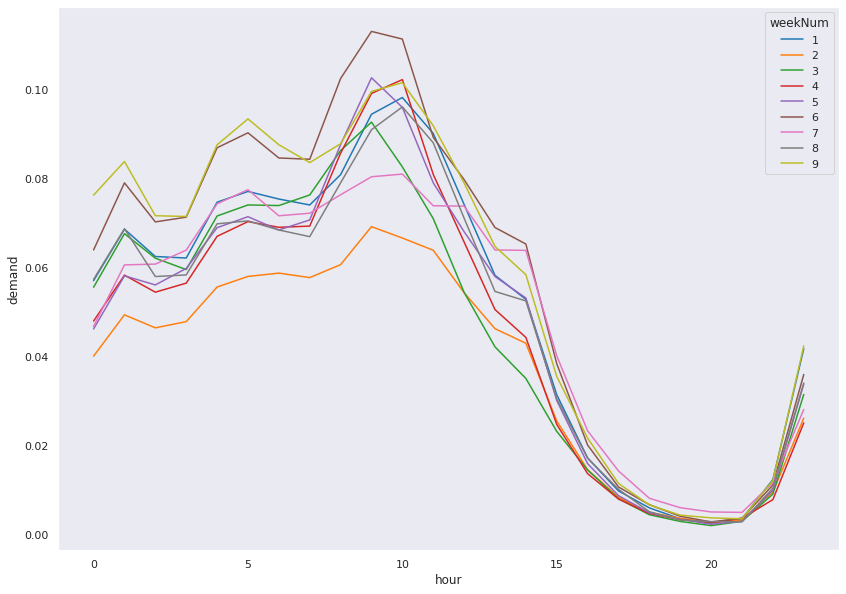

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = region4,
             ci = None, palette = "tab10")

This pattern seems to match up with that of the pattern that regions with relatively high demand seem to have, namely the increasing traffic demand throughout the morning followed by a sharp decrease until the evenings and a continuous increase throughout and into the next day.

However, the pattern in the morning does not match with that of the pattern in the morning for region 3. While region 3 has a minor fluctuation in traffic demand in the morning, this region fluctuates greatly thorughout the morning as it approaches and passes the morning peak hour period. 

In fact, the only time where the traffic demand remains roughly smooth is after 1500 hours where it follows a general 'U' shape.

Interestingly, the traffic demand changes greatly each week for the mornings however, it all smooths back into the same general curve shape and demand after 1500 hours regardless of what the week is.

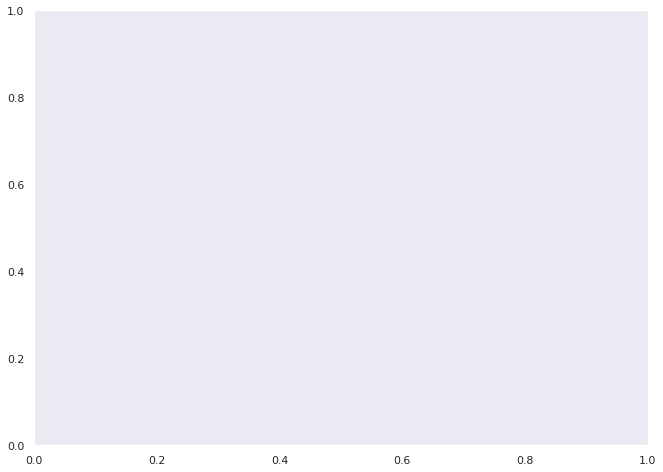

In [ ]:
allDays = [i for i in range(region4['day'].min(), region4['day'].max() + 1)] 

fig, ax = plt.subplots(figsize = (11, 8))
ax.grid(False)

def update(i):
    currentDate = allDays[i]

    data = region4[region4['day'] == currentDate]
    hexPlot = ax.hexbin(x = data['lon'], y = data['lat'], C = data['demand'], 
                        gridsize = 8, cmap = 'copper')

    currentWeek = int(i / 7) + 1
    dayOfWeek = int(i % 7) + 1

    ax.set_title("Region 4: Week {}, Day {}".format(currentWeek, dayOfWeek))
    ax.set_facecolor('black')

    return hexPlot

In [ ]:
animate = FuncAnimation(fig, update, repeat = True, 
                        interval = 600, frames = len(allDays))

HTML(animate.to_html5_video())

Similar to that of region 3, the spread of traffic demand does not seem to change much over the course of a week. Instead, the spread seems to remain relatively constant.

However, it does seem as if the traffic demand is clustered more around the region nearer to the bottom left than the other regions which may be worth noting.

In [ ]:
region4['dayType'] = region4.day.apply(lambda x: seperateDays(x, weekDay, weekEnd))
region4['dayType'].astype("string")
region4

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
11712     qp09sw    1      20:0  0.012612  ...   20      0        1  WeekDay
11713     qp09sw    1     14:30  0.246330  ...   14     30        1  WeekDay
11714     qp09sw    1      6:15  0.158939  ...    6     15        1  WeekDay
11715     qp09sw    1       5:0  0.102008  ...    5      0        1  WeekDay
11716     qp09sw    1       4:0  0.120789  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7753339   qp09s5   61     19:45  0.000000  ...   19     45        9  WeekDay
7753340   qp09s5   61      19:0  0.000000  ...   19      0        9  WeekDay
7753341   qp09s5   61       0:0  0.000000  ...    0      0        9  WeekDay
7753342   qp09s5   61     17:30  0.000000  ...   17     30        9  WeekDay
7753343   qp09s5   61     20:15  0.000000  ...   20     15        9  WeekDay

[691008 rows x 10 columns]

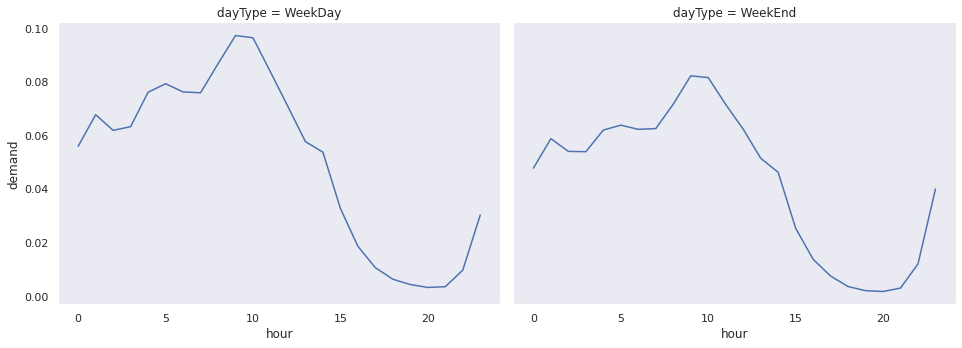

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(region4, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

As expected, like all the previous 3 regions, the general pattern of the traffic demand remains the same regardless of whether it is a weekday or a weekend. Additionally, the traffic demand during the weekdays is actually higher than during the weekends.

In fact, aside from the fact that the traffic demand is generally lower throughout the day during the weekends as compared to the weekdays, both curves could actually be superimposed onto each other.

Unfortunately, it seems impossible to conclude that region 3 is actually a region with high demand just based on what we have seen from region 4. 

While there are some differences between region 3 and region 4, thus far, region 4 actually has more similarities to the regions with high demand than region 3, especially in regards to its general trend of traffic demand over the course of a single day.

At the point, it seems as if region 3 is more of an outlier than anything.

##### Low Demand Regions in summary

In [ ]:
lowDemandRegions = pd.concat([region3, region4])
lowDemandRegions

geohash6  day timestamp    demand  ... hour minute  weekNum  dayType
486048    qp02zz    1      20:0  0.000000  ...   20      0        1  WeekDay
486049    qp02zz    1     14:30  0.391962  ...   14     30        1  WeekDay
486050    qp02zz    1      6:15  1.000000  ...    6     15        1  WeekDay
486051    qp02zz    1       5:0  0.871147  ...    5      0        1  WeekDay
486052    qp02zz    1       4:0  0.832315  ...    4      0        1  WeekDay
...          ...  ...       ...       ...  ...  ...    ...      ...      ...
7753339   qp09s5   61     19:45  0.000000  ...   19     45        9  WeekDay
7753340   qp09s5   61      19:0  0.000000  ...   19      0        9  WeekDay
7753341   qp09s5   61       0:0  0.000000  ...    0      0        9  WeekDay
7753342   qp09s5   61     17:30  0.000000  ...   17     30        9  WeekDay
7753343   qp09s5   61     20:15  0.000000  ...   20     15        9  WeekDay

[1253184 rows x 10 columns]

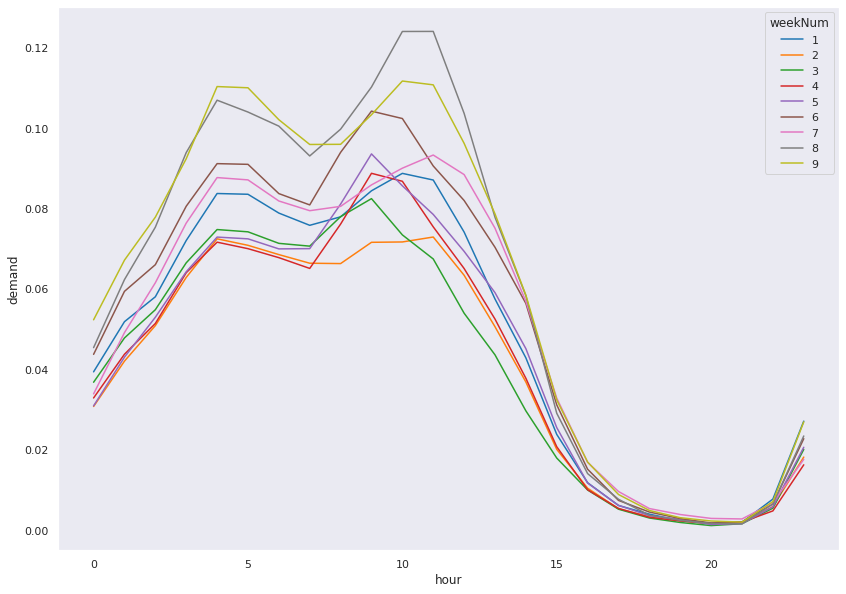

In [ ]:
sns.set(style = "dark", rc = {
    'figure.figsize': (14, 10),
    'axes.grid' : False
})

sns.lineplot(x = 'hour', y = 'demand', 
            hue = 'weekNum', data = lowDemandRegions,
             ci = None, palette = "tab10")

In general, low demand regions seem to have similar traffic demands in the second half of the day, after 1500 hours, regardless of what week it is. However, in direct contrast, the traffic demand in the morning fluctuates greatly depending on the week. 



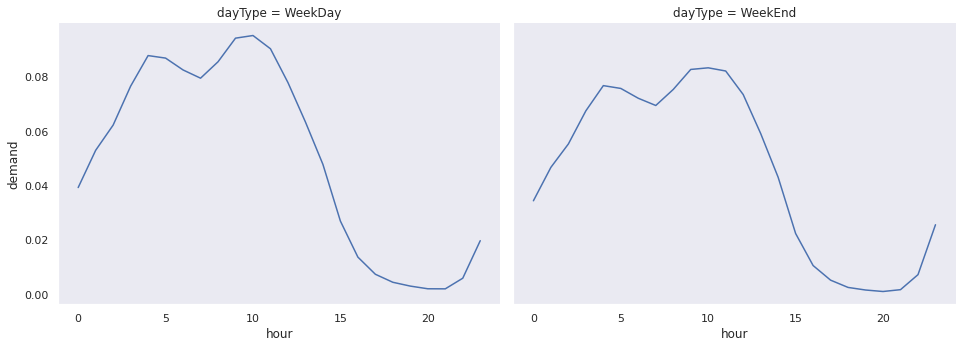

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(lowDemandRegions, col = 'dayType', 
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

Additionally, like regions with high demand, the pattern for weekdays versus. weekends are the same.

The general trend of the traffic demand over the course of the day remains similar enough that if not for the slight decrease in traffic demand, which only occurs in the mornings, the two line plots could be superimposed onto each other.

#### Comparing High Demand and Low Demand Regions

Now that we have discovered some of the general trends and patterns to high demand regions and low demand regions seperately, we can see that there are many similarities between both types of regions.

As such, it may be worth it to compare both regions together instead of analysing them seperately in order to gain more insight.

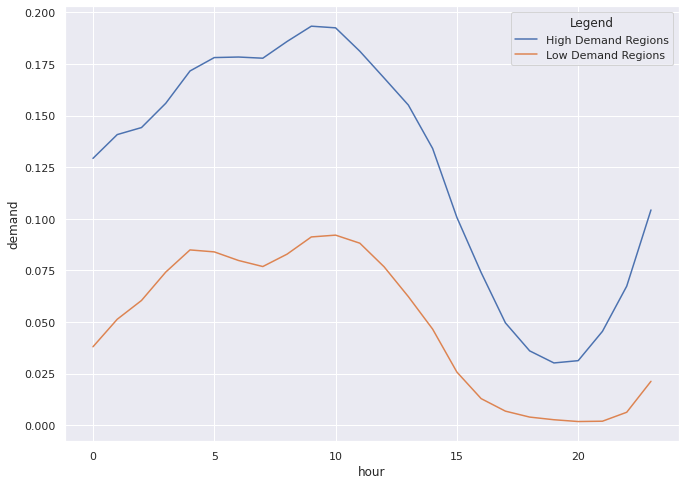

In [ ]:
sns.set(rc = {
    'figure.figsize': (11, 8)
})

sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = highDemandRegions)
sns.lineplot(x = "hour", y = "demand", 
             ci = None, data = lowDemandRegions)

plt.legend(title='Legend', loc='upper right', labels=['High Demand Regions', 'Low Demand Regions'])

The general trend for both high and low demand regions remain similar throughout the day. However, there are a few minor differences.

In the mornings, the traffic demand in high demand regions continue increasingly smoothly until reaching its peak. In comparison, the traffic demand in low demand regions actually decrease slightly between roughly 0600 to 0700 hours but it does have a roughly increasing trend in the mornings.

Additionally, in the afternoon, high demand regions experience a sharper drop in traffic demand than low demand regions which, while still maintaining an overall lower demand than high demand regions, do experience a smoother decrease and increase. Regardless, both regions do experience a roughly 'U' shape trend of traffic demand in the evenings.

In [ ]:
highDemandRegions['regionType'] = "highDemand"
lowDemandRegions['regionType'] = "lowDemand"

selectedRegions = pd.concat([highDemandRegions, lowDemandRegions])
selectedRegions

geohash6  day timestamp    demand  ... minute weekNum  dayType  regionType
0         qp03wc    1      20:0  0.004959  ...      0       1  WeekDay  highDemand
1         qp03wc    1     14:30  0.272885  ...     30       1  WeekDay  highDemand
2         qp03wc    1      6:15  0.308053  ...     15       1  WeekDay  highDemand
3         qp03wc    1       5:0  0.253679  ...      0       1  WeekDay  highDemand
4         qp03wc    1       4:0  0.267803  ...      0       1  WeekDay  highDemand
...          ...  ...       ...       ...  ...    ...     ...      ...         ...
7753339   qp09s5   61     19:45  0.000000  ...     45       9  WeekDay   lowDemand
7753340   qp09s5   61      19:0  0.000000  ...      0       9  WeekDay   lowDemand
7753341   qp09s5   61       0:0  0.000000  ...      0       9  WeekDay   lowDemand
7753342   qp09s5   61     17:30  0.000000  ...     30       9  WeekDay   lowDemand
7753343   qp09s5   61     20:15  0.000000  ...     15       9  WeekDay   lowDemand

[3209088 rows x 11 columns]

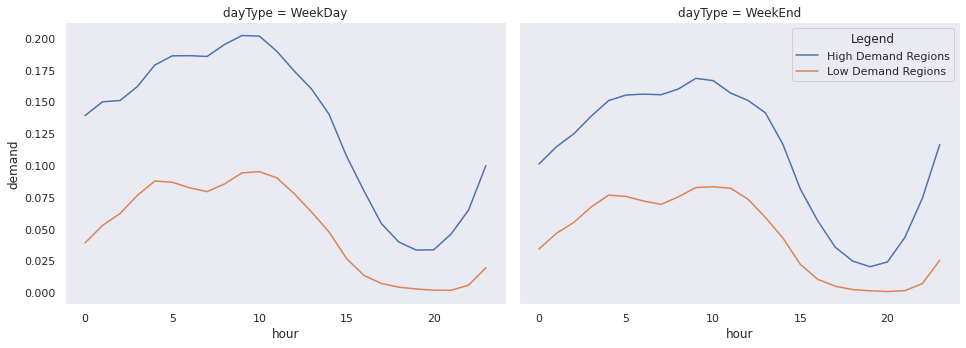

In [ ]:
sns.set(style = "dark", rc = {
    'axes.grid' : False
})

facetGrid_plt = sns.FacetGrid(selectedRegions, col = 'dayType', hue = 'regionType',
                              col_wrap = 5, height = 5, aspect = 1.3)
facetGrid_plt.map(sns.lineplot, 'hour', 'demand', ci = None)

plt.legend(title='Legend', loc='upper right', labels=['High Demand Regions', 'Low Demand Regions'])

As expected, the general trend remains the same between weekdays and weekends for both high and low demand regions like what we have already observed previously.

What is interesting this time however, is that the difference between the demand for both high and low demand regions is smaller in the evenings.

Additionally, during the weekends, the change in traffic demand over the course of the day is actually roughly similar for both high and low traffic demands aside from the sharper decline in traffic demand between 1600 and 2000 hours for high demand regions as compared to low demand regions.

### Problem Statement 1: Which areas have high / low traffic demand?

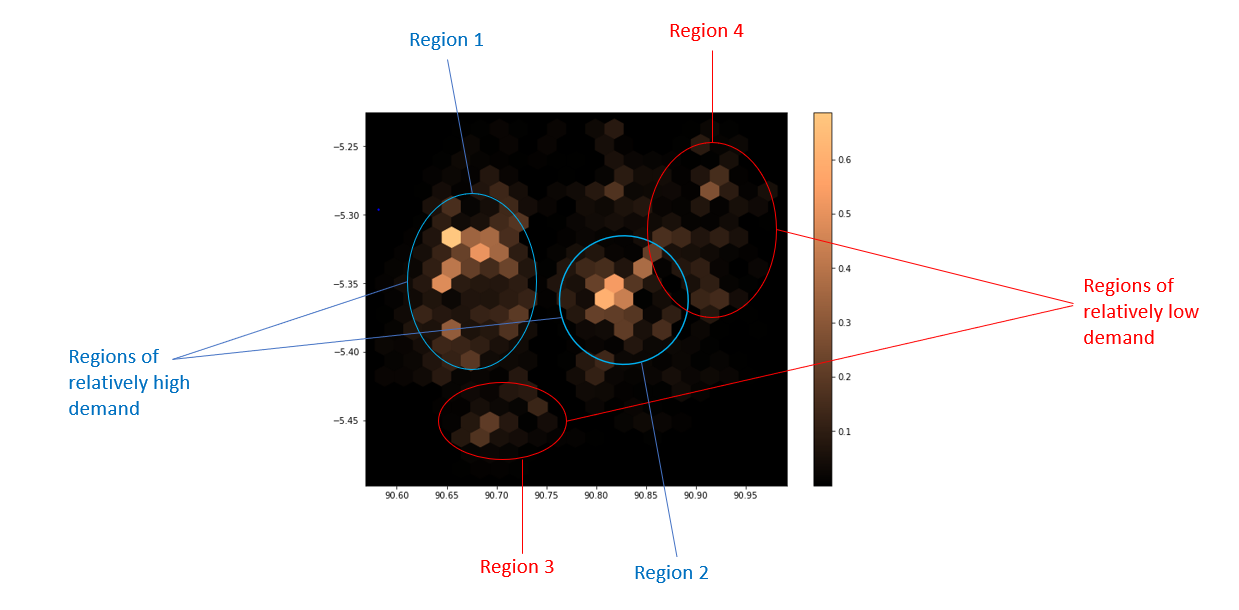

If we follow the color bar legend at the side, we can see that the brightly colored grids are regions with relatively high demand whereas the dimmer grids are regions with relatively lower demand.

The entirely black grids refer to areas which either have no data points or have little to no demand at all. If the area does not have a data point, it is because the geohash of this area was not provided in the original dataset. 

On the other hand, if the area has little to no demand at all but the geohash was provided in the dataset, it is likely that this geohash zone was missing a large majority of its data and thus, it appears to have almost no demand at all in this HexPlot as we filled in the missing rows with the appropriate data for all other columns but with 0 demand.

Regardless of the reasoning, for the purposes of this analysis, it is better for us to focus on the obvious regions that have either high or low demand and not to focus on the areas with little to no demand as the analysis may not be as accurate for low demand regions then.

Regions with obviously larger demand ( Estimated lat and lon range ):

    * Region1 -> ( -5.30 to -5.40 ), ( 90.60 to 90.75 )
    * Region2 -> ( -5.33 to -5.40 ), ( 90.75 to 90.85 )


Region of relatively lower demand ( Estimated lat and lon range ):

    * Region3 -> ( -5.40 to -5.50 ), ( 90.65 to 90.75 )
    * Region4 -> ( -5.30 to -5.40 ), ( 90.87 to 90.95 )

### Problem Statement 2: How does regional traffic demand change according to day / time?

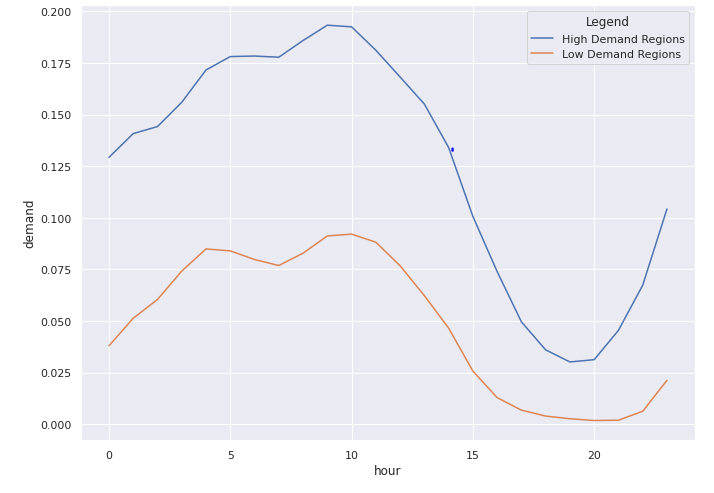

Generally, both high and low demand regions follow the same trend, with increasing demand starting from the early mornings until around the end of the peak hour period. Afterwhich, it starts to decrease in traffic demand, with a sharper decrease for high demand regions as compared to low demand regions, before increasing again at around 1900 to 2000 hours and into the next day.

This does more or less support our theory that high demand regions are CBD areas, whereby there is a significantly smaller traffic demand in the afternoons when everyone is at work especially when we take into account the sharper decline in traffic demand as compared to low demand regions.

On the other hand, these regions identified as relatively low demand regions are likely to be residential areas whereby it follows the same pattern throughout the day but with a smoother curve which is likely due to the fact that closer to home, one usually walks, takes their personal vehicles or stays at home which also accounts for the generally lower demand.

However, neither of these theories could explain why the traffic demand always increases after around 2000 hours. In fact, the most likely explanation we could come up with is that these regions contain entertainment facilities which could explain why the traffic demand goes back up as most people leave to go back home. 

Regardless, this does not support our theory of high demand regions being CBD areas and low demand regions being residential areas.

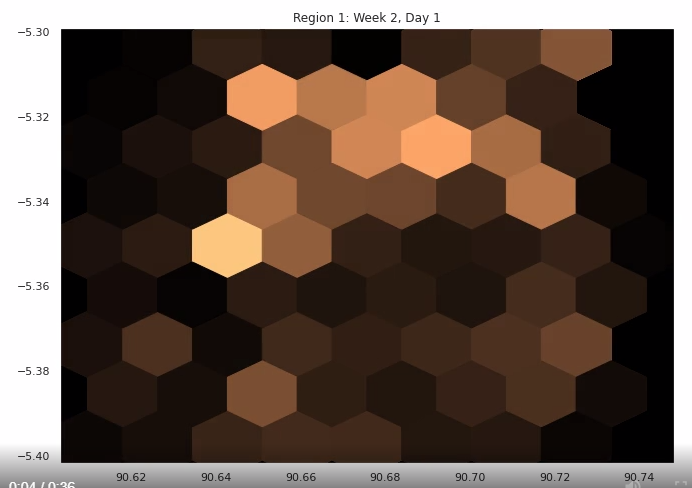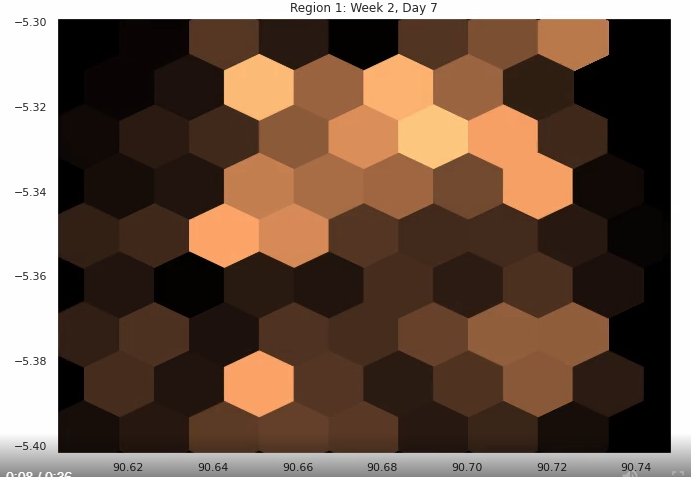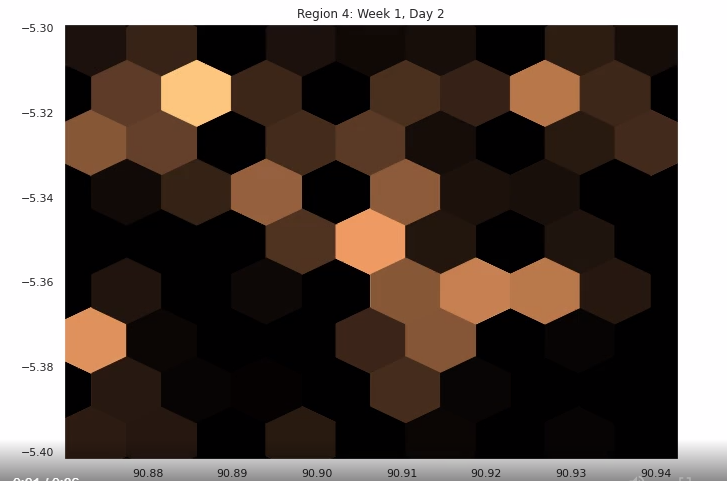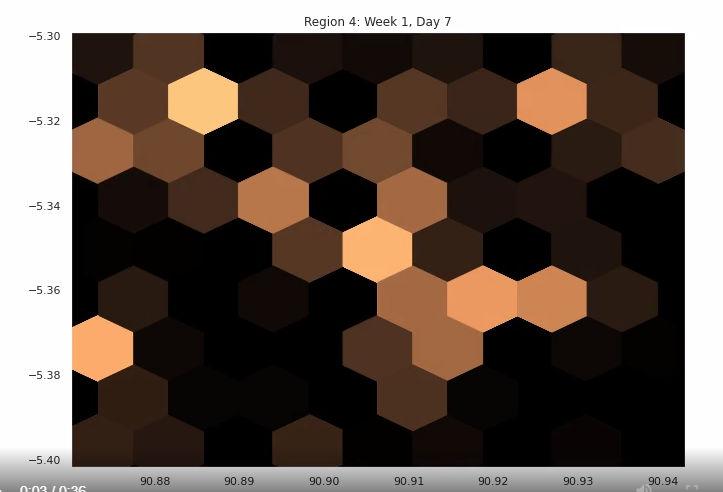

Taking region 1 as the representative for high demand regions and region 4 as the representative for low demand regions, we can see that in general, the spread of traffic demand increases during the weekends for high demand regions whereas this same spread remains the same regardless of whether it is a weekday or a weekend for low demand regions.

This does further support the theory that high demand regions are CBD areas as CBD areas usually have a number of middle to high-end restaurants which may be what contributes to the larger spread of traffic demand during the weekends as families head there to eat.

On the other hand, the spread of traffic demand doesn't really change much for low demand regions which does not fully support the theory that low demand regions are residential areas.

However, if we make the assumption that it is based on what we have observed so far, this constant spread in traffic demand could be explained by the fact that movements around a residential area would not change much whether it is a weekday or a weekend as on both types of days, individuals would leave their homes, but for different reasons.